# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
!pip install lightgbm


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [3]:
data = pd.read_csv('../raw_data/retail_train.csv')
item_features = pd.read_csv('../raw_data/product.csv')
user_features = pd.read_csv('../raw_data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [4]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [5]:
recommender = MainRecommender(data_train_lvl_1)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

In [6]:
recommender.get_als_recommendations(2375, N=5)

[899624, 832678, 1044078, 1102207, 883932]

In [7]:
recommender.get_own_recommendations(2375, N=5)

[948640, 918046, 847962, 907099, 873980]

In [8]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 1044078, 841220, 824758, 907631]

In [9]:
recommender.get_similar_users_recommendation(2496, N=5)

[9527417, 983659, 8090956, 872066, 914245]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [82]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [100]:
unique_users = data_train_lvl_1['user_id'].unique().tolist()
top_popular = recommender.overall_top_purchases[:50]

In [101]:
result_lvl_1['als_rec'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=50) if x in unique_users else top_popular)

In [102]:
result_lvl_1['own_rec'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50) if x in unique_users else top_popular)

In [105]:
result_lvl_1['similar_item_rec'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=50))

In [117]:
result_lvl_1['combined'] = result_lvl_1['user_id'].apply(lambda x: \
    result_lvl_1.loc[result_lvl_1.user_id == x]['als_rec'].tolist()[0][0:20] + \
    result_lvl_1.loc[result_lvl_1.user_id == x]['own_rec'].tolist()[0][0:20] + \
    result_lvl_1.loc[result_lvl_1.user_id == x]['similar_item_rec'].tolist()[0][0:10])

In [118]:
result_lvl_1.head(2)

,user_id,actual,als_rec,own_rec,similar_item_rec,combined
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[948670, 1119942, 1082212, 5577022, 856942, 11...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[824758, 1007512, 9297615, 5577022, 1132231, 9...","[948670, 1119942, 1082212, 5577022, 856942, 11..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[978332, 826835, 912739, 1021324, 10456408, 90...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[8090537, 5569845, 1044078, 985999, 880888, 81...","[978332, 826835, 912739, 1021324, 10456408, 90..."


In [119]:
def mean_recall_at_k(recommended_matrix, bought_matrix, k=5):
    
    rows_count = bought_matrix.shape[0]
    recall_by_row = [recall_at_k(recommended_matrix[i], bought_matrix[i], k) for i in range(rows_count)]
    recall_mean = np.mean(recall_by_row)

    return recall_mean

In [123]:
columns = result_lvl_1.columns[2:]

for column in columns:
    recall_mean = mean_recall_at_k(result_lvl_1[column], result_lvl_1.actual, k=200)
    print('{:35} {:.4f} %'.format(column, recall_mean * 100))

als_rec                             5.7269 %
own_rec                             6.8210 %
similar_item_rec                    4.8463 %
combined                            8.8937 %


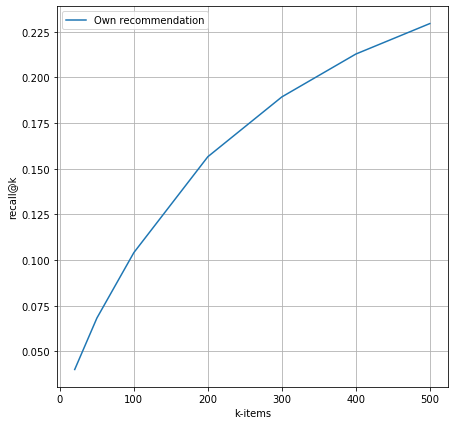

In [127]:
k_list = [20, 50, 100, 200, 300, 400, 500]

recall_list = [] 
users_list = result_lvl_1['user_id'].values

for k in k_list:
    own_recs = []
    for user in users_list: 
        own_recs.append(recommender.get_own_recommendations(user, N=k) if user in unique_users else top_popular)
    recall_list.append(mean_recall_at_k(own_recs, result_lvl_1.actual, k=k))
    

plt.figure(figsize=(7, 7))

plt.plot(k_list, recall_list, label="Own recommendation")
plt.xlabel('k-items')
plt.ylabel('recall@k')
plt.legend()
plt.grid()
plt.show()

По этому графику можно сделать вывод что чем больше k тем лучшею Скорее всего так выходит из-за низкого learn_rate, который я выставил у модели, это стоит поправить на рабочей модели. 

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

### Финальный проект

Мы уже прошли всю необходимуб теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 25%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 